hop_length:
- where each column x_frames[:, i] contains a contiguous slice of the input x[i * hop_length : i * hop_length + frame_length].

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

y, sr = librosa.load('../data/tmp/BCI_SL1_Rblau-Lweisshellblau_15_05_20_011_SS.wav', sr=500000)

n_fft = 1024
window_length = 488
hop_length = int(window_length * (1-0.875))
window = 'hamming'

lag = 2
n_mels = 256
fmin = 1000.
fmax = 84000.

odf_default = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
onset_default = librosa.onset.onset_detect(y=y, sr=sr, hop_length=hop_length, units='time')

print("Found {:d} onsets.".format(onset_default.shape[0]))
onset_times = librosa.frames_to_time(np.arange(len(odf_default)), sr=sr, hop_length=hop_length)

S = np.abs(librosa.stft(y, n_fft=n_fft, window=window, hop_length=hop_length, win_length=window_length))
SM = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, n_mels=n_mels)

%USERPROFILE%\scoop\apps\miniconda3\current\envs\bat_syllable_classifier\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
%USERPROFILE%\scoop\apps\miniconda3\current\envs\bat_syllable_classifier\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
%USERPROFILE%\scoop\apps\miniconda3\current\envs\bat_syllable_classifier\lib\site-packages\librosa\filters.py:284: User

Found 26 onsets.


compute the onset strength envelope and onset events with the superflux method

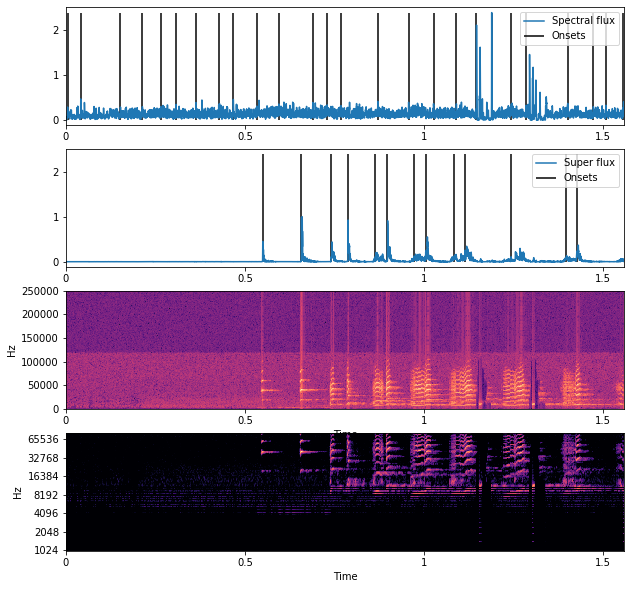

In [6]:

odf_sf = librosa.onset.onset_strength(S=S, sr=sr, hop_length=hop_length, lag=lag, max_size=1)
onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf, sr=sr, hop_length=hop_length, units='time')

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 1, 3)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='hz', x_axis='time', sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
plt.vlines(onset_sf, 0, odf_default.max(), label='Onsets', colors='black')
plt.subplot(4, 1, 4, sharex=ax)
librosa.display.specshow(librosa.power_to_db(SM, ref=np.max), y_axis='mel', x_axis='time', sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
plt.subplot(4, 1, 1, sharex=ax)
plt.plot(onset_times, odf_default, label='Spectral flux')
plt.vlines(onset_default, 0, odf_default.max(), label='Onsets')
plt.legend()
plt.subplot(4, 1, 2, sharex=ax)
plt.plot(onset_times, odf_sf, label='Super flux')
plt.vlines(onset_sf, 0, odf_default.max(), label='Onsets')
plt.legend()

test with mel spectrogram

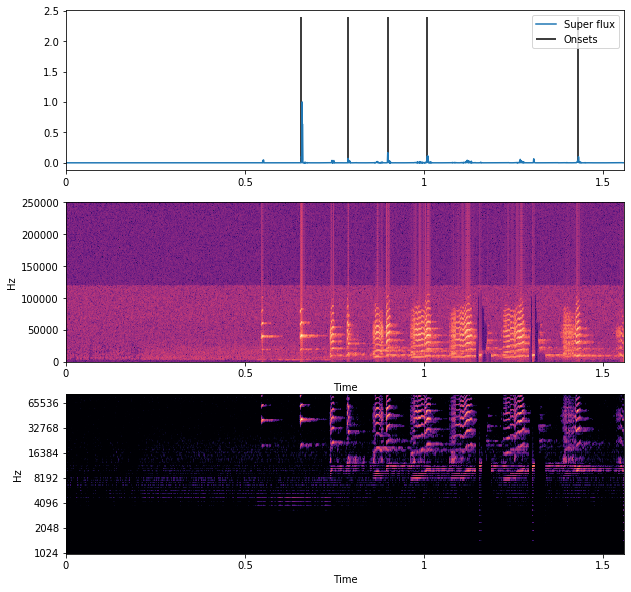

In [7]:
odf_sf = librosa.onset.onset_strength(S=SM, sr=sr, hop_length=hop_length, lag=lag, max_size=3)
onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf, sr=sr, hop_length=hop_length, units='time')

plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='hz', x_axis='time', sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
plt.vlines(onset_sf, 0, odf_default.max(), label='Onsets', colors='black')
plt.subplot(3, 1, 3, sharex=ax)
librosa.display.specshow(librosa.power_to_db(SM, ref=np.max), y_axis='mel', x_axis='time', sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
plt.subplot(3, 1, 1, sharex=ax)
plt.plot(onset_times, odf_sf, label='Super flux')
plt.vlines(onset_sf, 0, odf_default.max(), label='Onsets')
plt.legend()

Log for interactive will be written in log-2020-06-10_22-04-28
Already processed: tmp\sr500000_xpps2000_wHam\img\BCI_SL1_Rblau-Lweisshellblau_15_05_20_011_SS.htk


Using TensorFlow backend.
  0%|          | 0/1 [00:03<?, ?it/s]


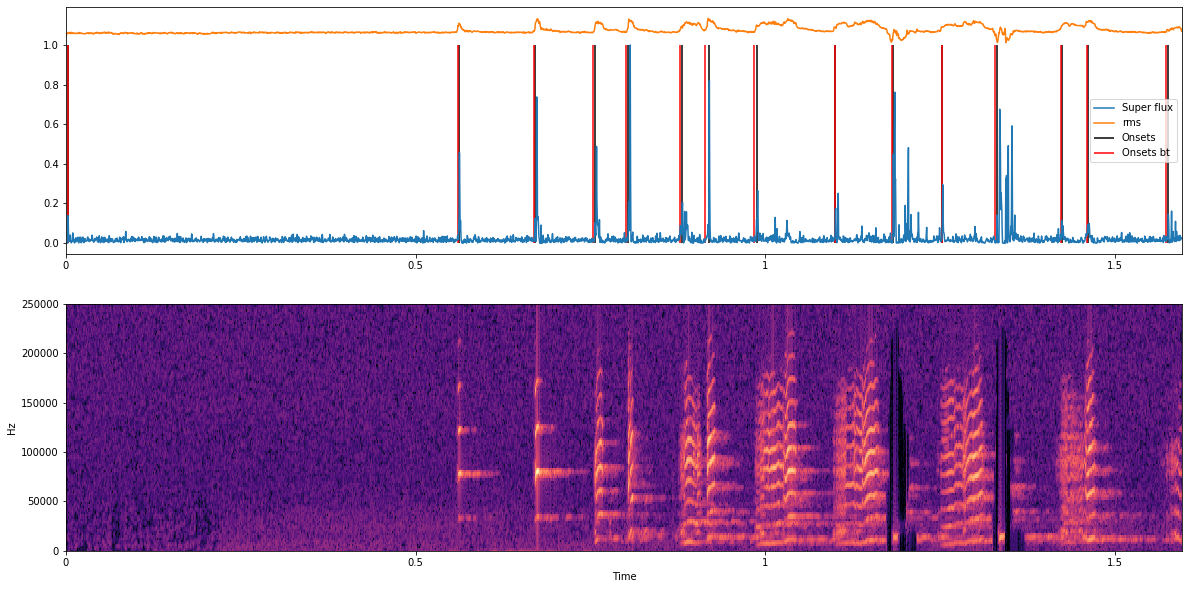

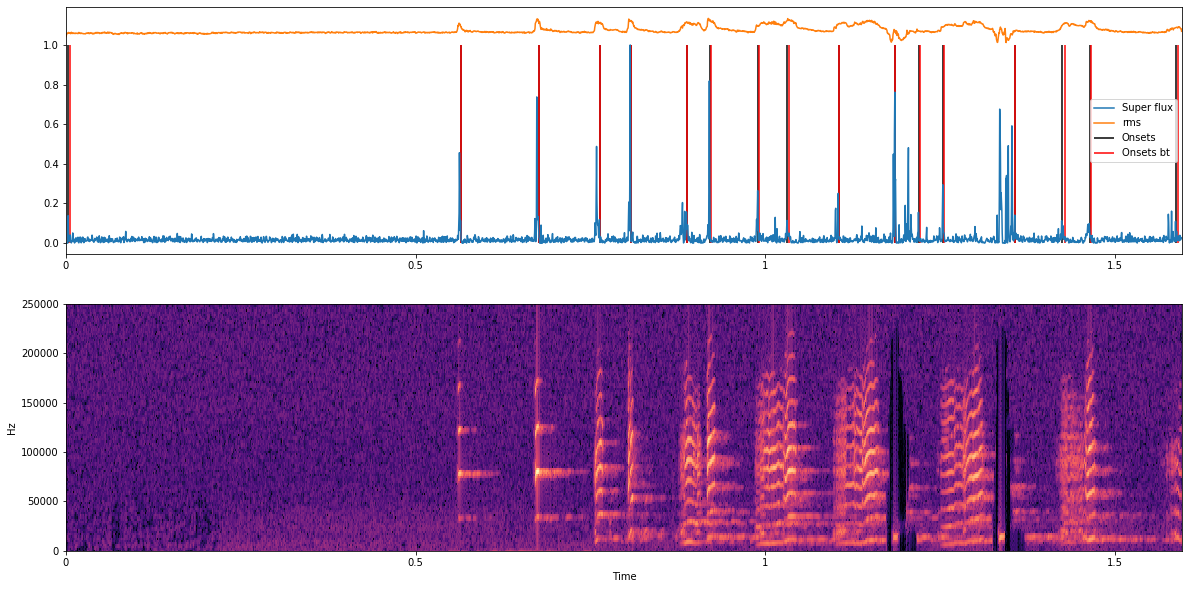

In [8]:
import datetime, json
from engine.helpers import write_file
from engine.feature_extraction import FeaturesFileList
from engine.nn.properties import ModelProperties
from engine.files.tasks import SourceTask
from engine.audio import load_audio, AudioFileList, File
from engine.metadata import metadata_db
from engine.settings import BSC_ROOT_DATA_FOLDER
from tqdm import tqdm

SAMPLING_RATE = 500000
LOW_FILTER = 4000
HIGH_FILTER = 120000
STRETCH = 10
HIGH_FREQ = SAMPLING_RATE / 2
LOW_PX, HIGH_PX = int((1 - LOW_FILTER / HIGH_FREQ) * 256), int((1 - HIGH_FILTER / HIGH_FREQ) * 256)

mdb = metadata_db('tmp/metadata.json')

class DumpTask(SourceTask):
	def __init__(self):
		tracks = [BSC_ROOT_DATA_FOLDER / 'tmp/BCI_SL1_Rblau-Lweisshellblau_15_05_20_011_SS.wav']
		super().__init__('emp', AudioFileList(
            [File(track, metadata=mdb.for_file(track)) for track in tracks], self
        ), {})

ff: FeaturesFileList = DumpTask().dest_list.create_spectrogram(sampling_rate=500000, x_pixels_per_sec=2000, window='Ham').img_features().run()
mp = ModelProperties(ff, prepare_args=dict(add_dim=False, normalize_samples=False), fit_args={})
x, _, _ = mp.get_features_xyw(variable_length=True)
hop_length = 256

for i, f in zip(x, tqdm(ff.files)):
	# i = (1 - i) * -120  # Convert to dBFS
	i = i[:, HIGH_PX:LOW_PX]
	i = np.flip(i.T, 0)
	i = librosa.db_to_power(i, ref=1)
	odf_sf = librosa.onset.onset_strength(S=i, sr=sr, hop_length=hop_length, lag=lag, max_size=11)
	onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf, sr=sr, hop_length=hop_length)
	onset_times = librosa.frames_to_time(np.arange(len(odf_sf)), sr=sr, hop_length=hop_length)

	rms = librosa.feature.rms(S=i)
	onset_bt_rms = librosa.onset.onset_backtrack(onset_sf, rms[0])

	onset_bt_rms = librosa.frames_to_time(onset_bt_rms, sr, hop_length)
	onset_sf = librosa.frames_to_time(onset_sf, sr, hop_length)

	plt.figure(figsize=(20, 10))
	ax = plt.subplot(2, 1, 2)
	librosa.display.specshow(librosa.power_to_db(i, ref=np.max), y_axis='hz', x_axis='time', sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
	plt.subplot(2, 1, 1, sharex=ax)
	plt.plot(onset_times, odf_sf, label='Super flux')
	plt.plot(onset_times, rms[0], label='rms')
	plt.vlines(onset_sf, 0, odf_sf.max(), label='Onsets')
	plt.vlines(onset_bt_rms, 0, odf_sf.max(), label='Onsets bt', color='red')
	plt.legend()

	onset_sf = librosa.onset.onset_detect(onset_envelope=np.flip(odf_sf), sr=sr, hop_length=hop_length)
	onset_bt_rms = librosa.onset.onset_backtrack(onset_sf, np.flip(rms[0]))
	onset_sf = len(odf_sf) - onset_sf
	onset_bt_rms = len(odf_sf) - onset_bt_rms

	onset_bt_rms = librosa.frames_to_time(onset_bt_rms, sr, hop_length)
	onset_sf = librosa.frames_to_time(onset_sf, sr, hop_length)

	plt.figure(figsize=(20, 10))
	ax = plt.subplot(2, 1, 2)
	librosa.display.specshow(librosa.power_to_db(i, ref=np.max), y_axis='hz', x_axis='time', sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
	plt.subplot(2, 1, 1, sharex=ax)
	plt.plot(onset_times, odf_sf, label='Super flux')
	plt.plot(onset_times, rms[0], label='rms')
	plt.vlines(onset_sf, 0, odf_sf.max(), label='Onsets')
	plt.vlines(onset_bt_rms, 0, odf_sf.max(), label='Onsets bt', color='red')
	plt.legend()

test mean amplitude per freq denoise fn

  0%|          | 0/1 [00:00<?, ?it/s]


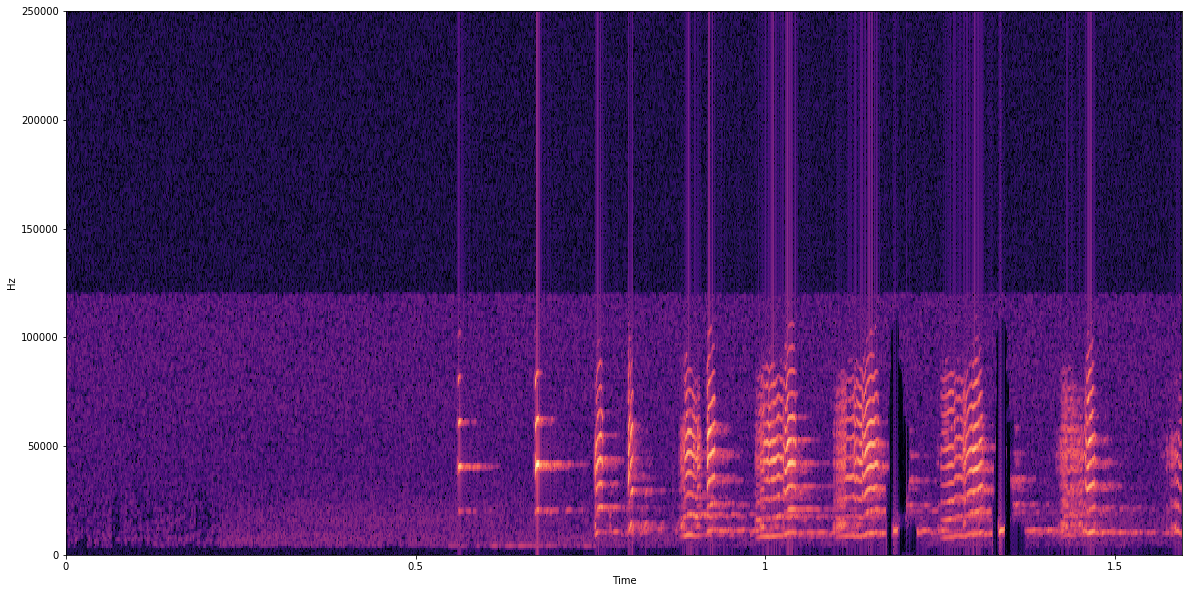

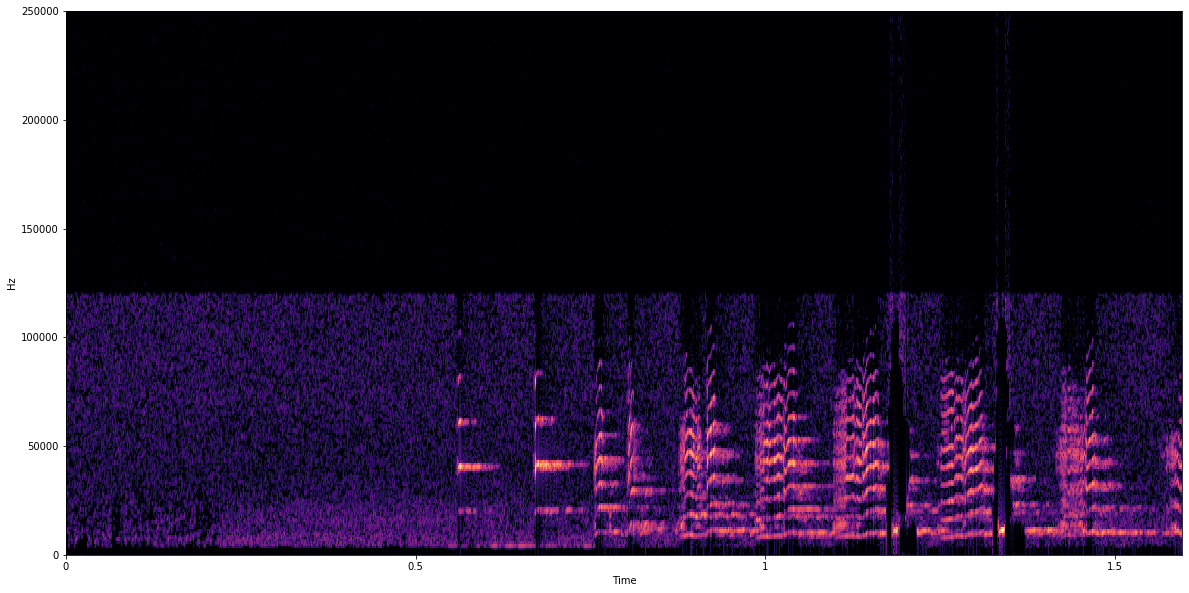

In [9]:
def mean_amplitude_per_freq_denoise(data):
	me = np.mean(data, 1)
	data = data - me[:, np.newaxis]
	# remove anything below 0
	data.clip(min=0, out=data)
	return data

for i, f in zip(x, tqdm(ff.files)):
	for denoise in [False, True]:
		data = i
		if denoise: data = mean_amplitude_per_freq_denoise(data)
		# i = i[:, HIGH_PX:LOW_PX]
		data = np.flip(data.T, 0)
		data = librosa.db_to_power(data, ref=1)

		plt.figure(figsize=(20, 10))
		librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='hz', x_axis='time', sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)

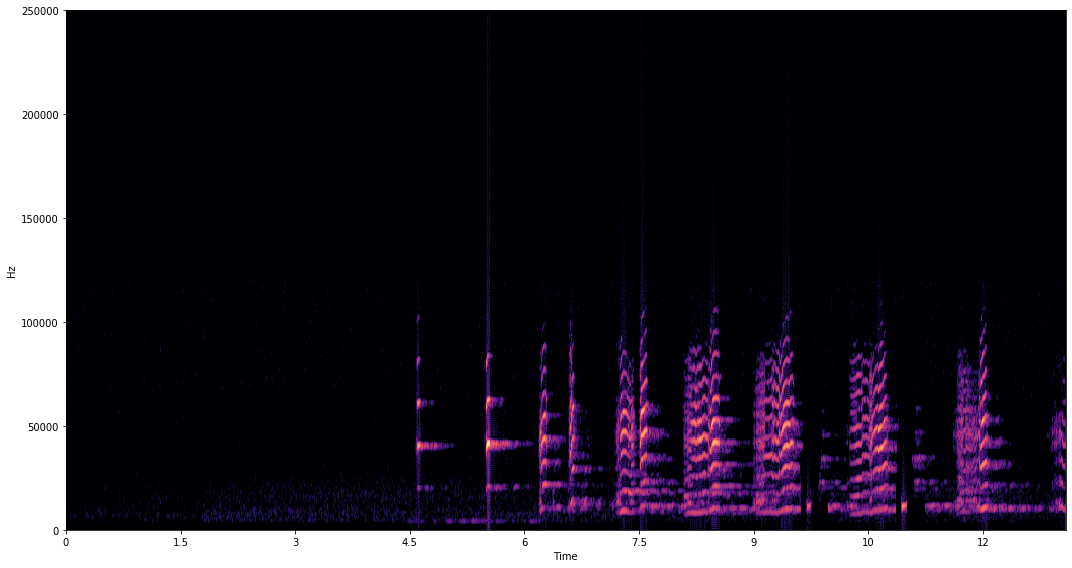

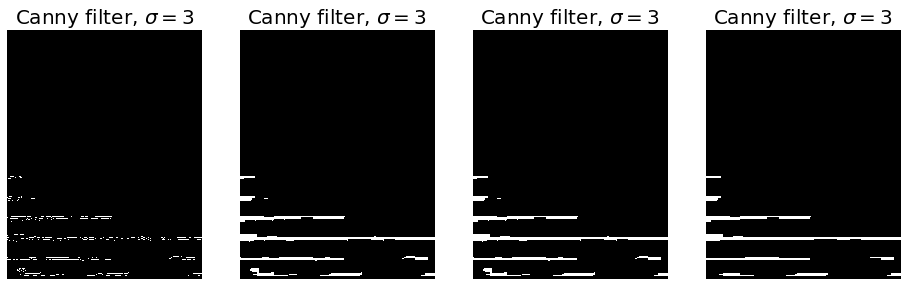

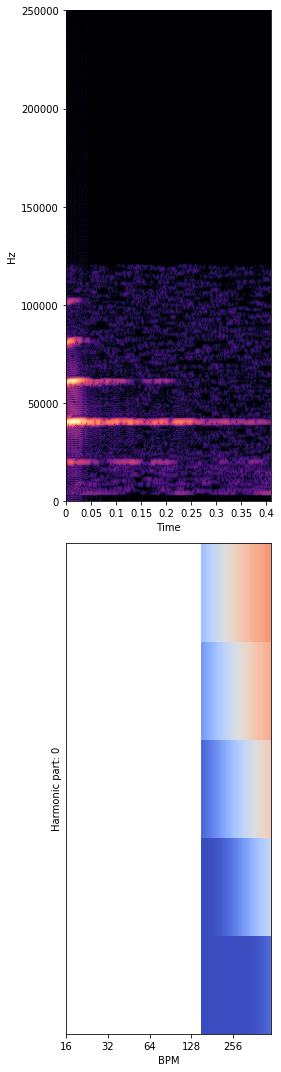

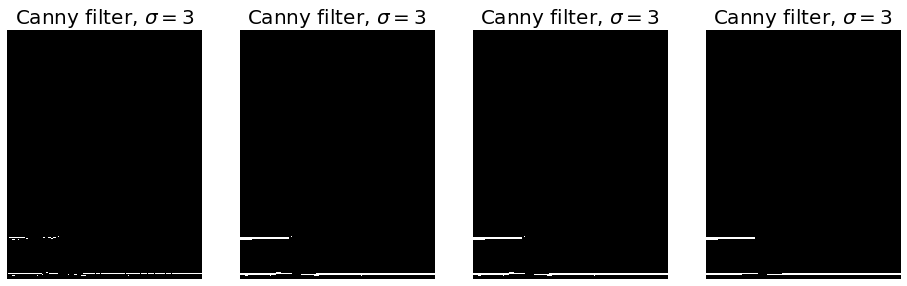

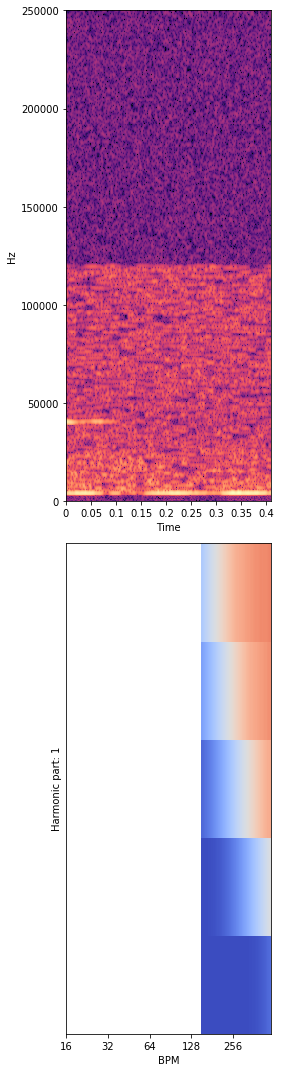

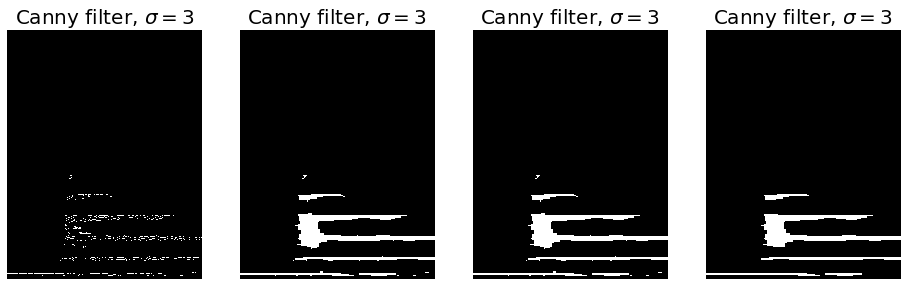

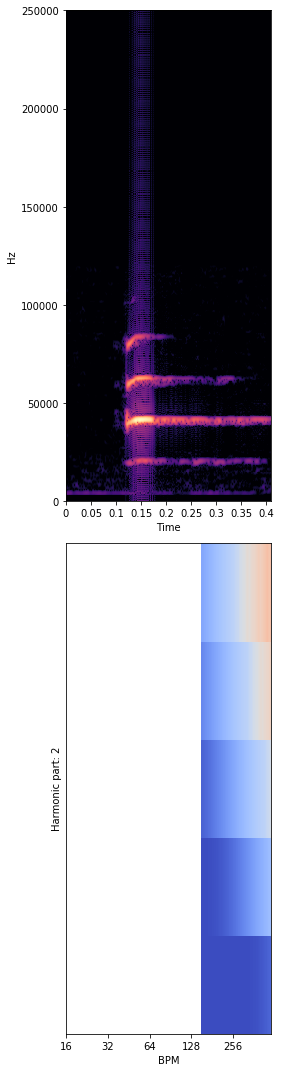

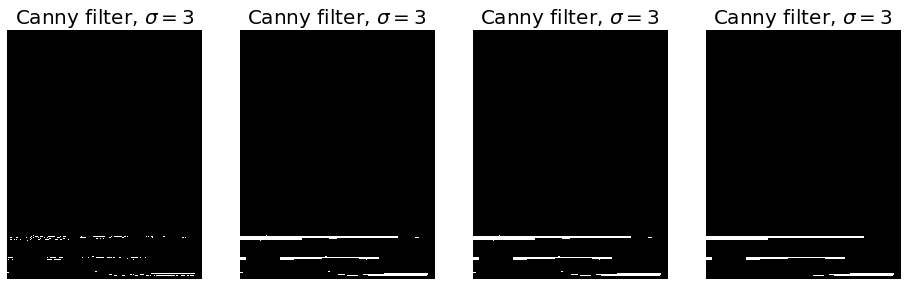

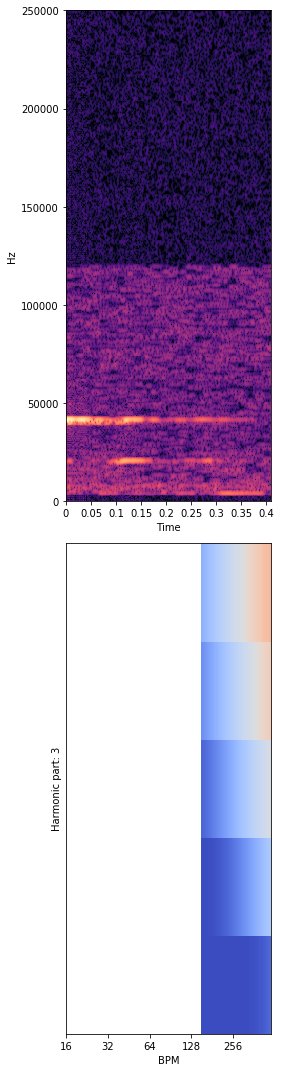

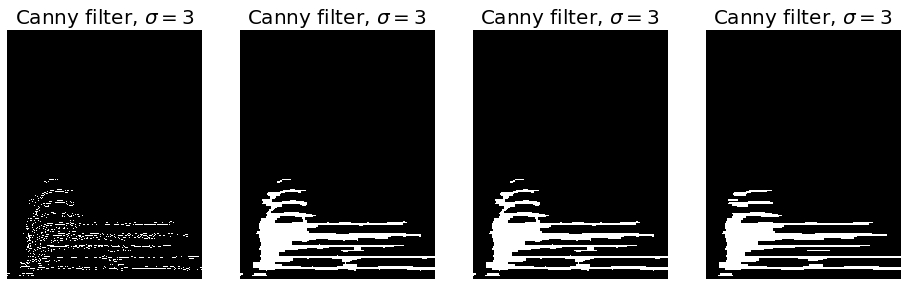

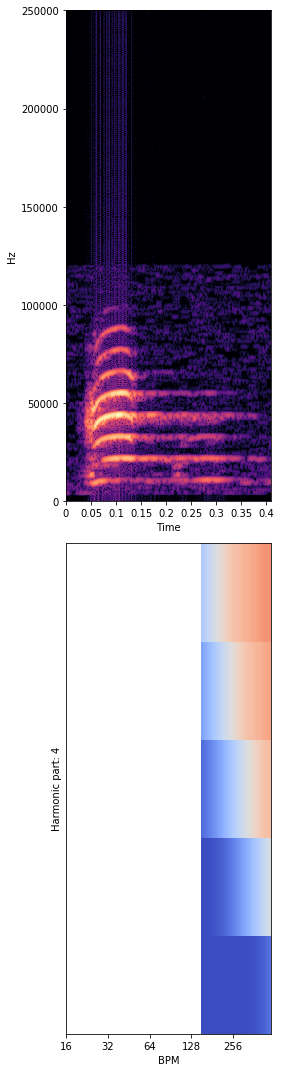

In [16]:
from skimage import feature
from utils.canny import canny
from skimage import util
from skimage.morphology import closing, binary_closing, binary_opening
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
n_fft = 1024
lag = 2
window_length = 488
hop_length = int(window_length * (1-0.875))
window = 'hamming'
files = ['../data/tmp/BCI_SL1_Rblau-Lweisshellblau_15_05_20_011_SS.wav']
offeset_length = 400
sample_offset = librosa.frames_to_samples(offeset_length, hop_length, n_fft)

for file in files:
	y, sr = librosa.load(file, sr=500000)
	S = np.abs(librosa.stft(y, n_fft=n_fft, window=window, hop_length=hop_length, win_length=window_length))
	i_filtered = S

	odf_sf = librosa.onset.onset_strength(S=i_filtered, sr=sr, hop_length=hop_length, lag=lag, max_size=11)
	onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf, sr=sr, hop_length=hop_length)
	onset_times = librosa.frames_to_time(np.arange(len(odf_sf)), sr=sr, hop_length=hop_length)
	rms = librosa.feature.rms(S=i_filtered)
	onset_bt_rms = librosa.onset.onset_backtrack(onset_sf, rms[0])
	plt.figure(figsize=(15, 8))
	librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, y_axis='hz', x_axis='time')
	plt.tight_layout()
	plt.show()

	for onset in onset_bt_rms:
		onset_frame = librosa.frames_to_samples(onset, hop_length, n_fft)

		for onset_part in range(5):
			onset_offset = onset + (380 * onset_part)
			onset_offset_frame = librosa.frames_to_samples(onset_offset, hop_length, n_fft)
			i_onset = i_filtered[:,onset_offset:onset_offset+offeset_length]
			y_onset = y[onset_offset_frame:onset_offset_frame+sample_offset]

			edges2 = canny(np.flip(i_onset, 0), sigma=2, low_threshold=0.01, high_threshold=0.2)
			plt.figure(figsize=(16, 15))
			ax3 = plt.subplot(1, 4, 1)
			ax3.imshow(edges2, cmap=plt.cm.gray)
			ax3.axis('off')
			ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
			edges2 = binary_closing(edges2, selem=np.ones((5,20), dtype=np.uint8))
			ax3 = plt.subplot(1, 4, 2)
			ax3.imshow(edges2, cmap=plt.cm.gray)
			ax3.axis('off')
			ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
			edges2 = binary_closing(edges2, selem=np.ones((3,20), dtype=np.uint8))
			# edges2 = binary_opening(edges2, selem=np.ones((3,20), dtype=np.uint8))
			ax3 = plt.subplot(1, 4, 3)
			ax3.imshow(edges2, cmap=plt.cm.gray)
			ax3.axis('off')
			ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
			edges2 = binary_opening(edges2, selem=np.ones((1,20), dtype=np.uint8))
			ax3 = plt.subplot(1, 4, 4)
			ax3.imshow(edges2, cmap=plt.cm.gray)
			ax3.axis('off')
			ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

			# edges2 = feature.canny(edges2, sigma=0)

			h_range = [1, 2, 3, 4, 5]
			tempi = np.mean(librosa.feature.tempogram(y=y_onset, sr=sr), axis=1)
			t_harm = librosa.interp_harmonics(tempi, librosa.tempo_frequencies(len(tempi), sr=sr), h_range)
			plt.figure(figsize=(4, 15))
			plt.subplot(2, 1, 1)
			librosa.display.specshow(librosa.amplitude_to_db(i_onset, ref=np.max), sr=sr, y_axis='hz', x_axis='time')
			plt.subplot(2, 1, 2)
			librosa.display.specshow(t_harm, sr=sr, x_axis='tempo')
			plt.ylabel('Harmonic part: ' + str(onset_part))
			plt.tight_layout()
			plt.show()

		break
		# h_range = [1, 2]
		# i_harm = librosa.interp_harmonics(i_onset, librosa.fft_frequencies(sr=sr, n_fft=n_fft), h_range, axis=0)
		# plt.figure(figsize=(15, 8))
		# librosa.display.specshow(i_harm, sr=sr, x_axis='tempo')
		# plt.figure(figsize=(15, 15))
		# plt.subplot(2, 1, 1)
		# start = 1
		# for pos, _sh in enumerate(i_harm, start):
		# 	plt.subplot(2, 1, pos)
		# 	librosa.display.specshow(librosa.amplitude_to_db(_sh, ref=i_onset.max()), sr=sr, y_axis='hz', x_axis='time')
		#
		# 	plt.title('h={:.3g}'.format(h_range[pos-start]))
		# 	plt.yticks([])
		# plt.tight_layout()
		# plt.show()
		# break